# Match test ($e_0$ Vs ${\cal M}^*_\%$)

In [2]:
import os
from pycbc.filter.matchedfilter import match
from pycbc.types.frequencyseries import FrequencySeries
import numpy as np
import bilby
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

C = 299792458.
G = 6.67408*1e-11
Mo = 1.989*1e30
Mpc = 3.086*1e22

In [5]:
Gamma = 0.5772156649015329
Pi = np.pi
MTSUN_SI = 4.925491025543576e-06

def findchirp_chirptime(m1, m2, fmin):
    """
    Time taken from f_min to f_lso (last stable orbit). 3.5PN in fourier phase considered.

    Parameters
    ----------
    m1 : `float`
        Mass of the first body in solar masses.
    m2 : `float`
        Mass of the second body in solar masses.
    fmin : `float`
        Lower frequency cutoff.

    Returns
    -------
    chirp_time : float
        Time taken from f_min to f_lso (last stable orbit frequency).
    """

    # variables used to compute chirp time
    m = m1 + m2
    eta = m1 * m2 / m / m
    c0T = c2T = c3T = c4T = c5T = c6T = c6LogT = c7T = 0.0

    c7T = Pi * (
        14809.0 * eta * eta / 378.0 - 75703.0 * eta / 756.0 - 15419335.0 / 127008.0
    )

    c6T = (
        Gamma * 6848.0 / 105.0
        - 10052469856691.0 / 23471078400.0
        + Pi * Pi * 128.0 / 3.0
        + eta * (3147553127.0 / 3048192.0 - Pi * Pi * 451.0 / 12.0)
        - eta * eta * 15211.0 / 1728.0
        + eta * eta * eta * 25565.0 / 1296.0
        + eta * eta * eta * 25565.0 / 1296.0
        + np.log(4.0) * 6848.0 / 105.0
    )
    c6LogT = 6848.0 / 105.0

    c5T = 13.0 * Pi * eta / 3.0 - 7729.0 * Pi / 252.0

    c4T = 3058673.0 / 508032.0 + eta * (5429.0 / 504.0 + eta * 617.0 / 72.0)
    c3T = -32.0 * Pi / 5.0
    c2T = 743.0 / 252.0 + eta * 11.0 / 3.0
    c0T = 5.0 * m * MTSUN_SI / (256.0 * eta)

    # This is the PN parameter v evaluated at the lower freq. cutoff
    xT = np.power(Pi * m * MTSUN_SI * fmin, 1.0 / 3.0)
    x2T = xT * xT
    x3T = xT * x2T
    x4T = x2T * x2T
    x5T = x2T * x3T
    x6T = x3T * x3T
    x7T = x3T * x4T
    x8T = x4T * x4T

    # Computes the chirp time as tC = t(v_low)
    # tC = t(v_low) - t(v_upper) would be more
    # correct, but the difference is negligble.
    return (
        c0T
        * (
            1
            + c2T * x2T
            + c3T * x3T
            + c4T * x4T
            + c5T * x5T
            + (c6T + c6LogT * np.log(xT)) * x6T
            + c7T * x7T
        )
        / x8T
    )

In [3]:
time_of_event = 1126259642.413
post_trigger_duration = 1.
duration = 309.0
analysis_start = time_of_event + post_trigger_duration - duration
sampling_frequency = 2048.
f_min = 20.0

injection_parameters = {'mass_1':1.61, 'mass_2':1.18, 'eccentricity':0.1, 'a_1':0., 'a_2':0., 'tilt_1':0., 'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':38.87, 'theta_jn':2.52, 'psi':3.293627, 'phase':0., 'geocent_time':1246527184.169434, 'ra':3.45, 'dec':-0.41,}

In [4]:
############# TF2Ecck waveform model ################
waveform_arguments1 = dict(waveform_approximant='TaylorF2Ecck',
                          reference_frequency=f_min, minimum_frequency=f_min)

waveform_generator1 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_eccentric_binary_black_hole_no_spins,
    parameters=injection_parameters, waveform_arguments=waveform_arguments1)

############# TF2Ecch waveform model ################
waveform_arguments2 = dict(waveform_approximant='TaylorF2Ecch',
                          reference_frequency=f_min, minimum_frequency=f_min)

waveform_generator2 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_eccentric_binary_black_hole_no_spins,
    parameters=injection_parameters, waveform_arguments=waveform_arguments2)

############# TF2Ecc waveform model ################
waveform_arguments3 = dict(waveform_approximant='TaylorF2Ecc',
                          reference_frequency=f_min, minimum_frequency=f_min, pn_phase_order=6, pn_tidal_order=0)

waveform_generator3 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_eccentric_binary_black_hole_no_spins,
    parameters=injection_parameters, waveform_arguments=waveform_arguments3)

############# TaylorF2 waveform model ################
waveform_arguments4 = dict(waveform_approximant='TaylorF2',
                          reference_frequency=f_min, minimum_frequency=f_min, pn_phase_order=6, pn_amplitude_order=0, pn_tidal_order=0)

waveform_generator4 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_eccentric_binary_black_hole_no_spins,
    parameters=injection_parameters, waveform_arguments=waveform_arguments4)

ifos = bilby.gw.detector.InterferometerList(['L1'])
ifos.set_strain_data_from_zero_noise(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=analysis_start)

06:29 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_eccentric_binary_black_hole_no_spins
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
06:29 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_eccentric_binary_black_hole_no_spins
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
06:29 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_eccentric_binary_black_hole_no_spins
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
06:29 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_eccentric_binary_black_hole_no_spins
  time_domain_source_model: None
  parameter_conversi

In [15]:
size1 = 100
mass_1 = np.random.uniform(1.0, 3.0, size1)
mass_2 = np.random.uniform(1.0, 3.0, size1)
# swap if mass_1 < mass_2
idx_ = mass_1 < mass_2
mass_1[idx_], mass_2[idx_] = mass_2[idx_], mass_1[idx_]

size2 = 20 # number of eccentricity values
eccn_array = np.linspace(0.0,0.25,size2)

## TaylorrF2Ecck vs TaylorF2Ecch

In [16]:
if not os.path.exists('match_array_12.npy'):
    match_array_12 = []
    for i in range(size1):

        mass_1_ = mass_1[i]
        mass_2_ = mass_2[i]
        #f_max = 128.
        f_max = (C**3)/( G*(mass_1_+mass_2_)*Mo*np.pi*6**(3/2) )

        safety = 1.2
        approx_duration = safety * findchirp_chirptime(mass_1_, mass_2_, f_min)
        duration = np.ceil(approx_duration + 2.0)

        match_array_list = []
        for eccn in eccn_array:

            injection_parameters = {'mass_1':mass_1_, 'mass_2':mass_2_, 'eccentricity':eccn, 'a_1':0., 'a_2':0., 'tilt_1':0., 'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':38.87, 'theta_jn':2.52, 'psi':3.293627, 'phase':0., 'geocent_time':1246527184.169434, 'ra':3.45, 'dec':-0.41,}
            
            polas_a = waveform_generator1.frequency_domain_strain(parameters = injection_parameters) # TF2Ecck
            polas_b = waveform_generator2.frequency_domain_strain(parameters = injection_parameters) # TF2Ecch
            arr_a = FrequencySeries(polas_a['plus'], delta_f=1/duration)
            arr_b = FrequencySeries(polas_b['plus'], delta_f=1/duration)
            psd_ = FrequencySeries(ifos[0].power_spectral_density_array, delta_f=1/duration)

            
            match_array_list.append(match(arr_a, arr_b, psd=psd_, low_frequency_cutoff=f_min, high_frequency_cutoff=f_max))

        match_array_12.append(np.array(match_array_list)[:,0])
    # save data
    np.save('match_array_12.npy', np.array(match_array_12))
else:
    match_array_12 = np.load('match_array_12.npy')

## TaylorrF2Ecck vs TaylorF2Ecc

In [18]:
if not os.path.exists('match_array_13.npy'):
    match_array_13 = []
    for i in range(size1):

        mass_1_ = mass_1[i]
        mass_2_ = mass_2[i]
        #f_max = 128.
        f_max = (C**3)/( G*(mass_1_+mass_2_)*Mo*np.pi*6**(3/2) )

        safety = 1.2
        approx_duration = safety * findchirp_chirptime(mass_1_, mass_2_, f_min)
        duration = np.ceil(approx_duration + 2.0)
        # duration = 309.

        match_array_list = []
        for eccn in eccn_array:

            injection_parameters = {'mass_1':mass_1_, 'mass_2':mass_2_, 'eccentricity':eccn, 'a_1':0., 'a_2':0., 'tilt_1':0., 'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':38.87, 'theta_jn':2.52, 'psi':3.293627, 'phase':0., 'geocent_time':1246527184.169434, 'ra':3.45, 'dec':-0.41,}
            
            polas_a = waveform_generator1.frequency_domain_strain(parameters = injection_parameters) # TF2Ecck
            polas_b = waveform_generator3.frequency_domain_strain(parameters = injection_parameters) # TF2Ecc
            arr_a = FrequencySeries(polas_a['plus'], delta_f=1/duration)
            arr_b = FrequencySeries(polas_b['plus'], delta_f=1/duration)
            psd_ = FrequencySeries(ifos[0].power_spectral_density_array, delta_f=1/duration)

            
            match_array_list.append(match(arr_a, arr_b, psd=psd_, low_frequency_cutoff=f_min, high_frequency_cutoff=f_max))

        match_array_13.append(np.array(match_array_list)[:,0])
    # save data
    np.save('match_array_13.npy', np.array(match_array_13))
else:
    match_array_13 = np.load('match_array_13.npy')
# 10,100 -> 14min

## TaylorrF2Ecck vs TaylorF2

In [19]:
if not os.path.exists('match_array_14.npy'):
    eccn_array_ = np.linspace(0.0,0.04,10)
    match_array_14 = []
    for i in tqdm(range(size1)):

        mass_1_ = mass_1[i]
        mass_2_ = mass_2[i]
        #f_max = 128.
        f_max = (C**3)/( G*(mass_1_+mass_2_)*Mo*np.pi*6**(3/2) )

        safety = 1.2
        approx_duration = safety * findchirp_chirptime(mass_1_, mass_2_, f_min)
        duration = np.ceil(approx_duration + 2.0)
        # duration = 309.

        match_array_list = []
        for eccn in eccn_array_:

            injection_parameters = {'mass_1':mass_1_, 'mass_2':mass_2_, 'eccentricity':eccn, 'a_1':0., 'a_2':0., 'tilt_1':0., 'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':38.87, 'theta_jn':2.52, 'psi':3.293627, 'phase':0., 'geocent_time':1246527184.169434, 'ra':3.45, 'dec':-0.41,}
            
            polas_a = waveform_generator1.frequency_domain_strain(parameters = injection_parameters) # TF2Ecck
            polas_b = waveform_generator4.frequency_domain_strain(parameters = injection_parameters) # TF2
            arr_a = FrequencySeries(polas_a['plus'], delta_f=1/duration)
            arr_b = FrequencySeries(polas_b['plus'], delta_f=1/duration)
            psd_ = FrequencySeries(ifos[0].power_spectral_density_array, delta_f=1/duration)

            
            match_array_list.append(match(arr_a, arr_b, psd=psd_, low_frequency_cutoff=f_min, high_frequency_cutoff=f_max))

        match_array_14.append(np.array(match_array_list)[:,0])
    # save data
    np.save('match_array_14.npy', np.array(match_array_14))
else:
    match_array_14 = np.load('match_array_14.npy')

## Plot

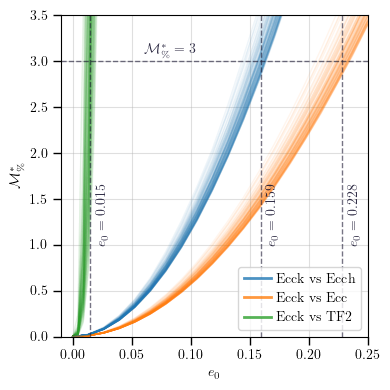

In [20]:
size1 = 100
size2 = 20

# Setup the figure
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})
plt.figure(figsize=(4., 4.))

# First plot (mismatch percentage)
for j in range(size1):
    plt.plot(eccn_array, (1 - match_array_12[j]) * 100, 'C0', alpha=0.07, linewidth=1)
    plt.plot(eccn_array, (1 - match_array_13[j]) * 100, 'C1', alpha=0.07, linewidth=1)
    plt.plot(np.linspace(0.0, 0.04, 10), (1 - match_array_14[j]) * 100, 'C2', alpha=0.07, linewidth=1)

# Labeling the first plot
plt.xlabel(r"$e_0$")
plt.ylabel(r"${\cal M}^*_{\%}$")
legend = plt.legend(['Ecck vs Ecch', 'Ecck vs Ecc', 'Ecck vs TF2'], handlelength=2, loc='lower right', bbox_to_anchor=(1.0, 0.0), frameon=True)
# Modify line width for legend entries
for handle in legend.get_lines():
    handle.set_linewidth(2)
    handle.set_alpha(0.8)

plt.xlim(-0.01, 0.25)
plt.ylim(0.0, 3.5)
plt.axhline(y=3.0, color='#1B1833', linestyle='--', linewidth=1, alpha=0.6)
plt.text(0.06, 3.07, r'${\cal M}^*_{\%}=3$', color='#1B1833', fontsize=10, alpha=0.9)

plt.axvline(x=0.014661661290850475, color='#1B1833', linestyle='--', linewidth=1, alpha=0.6)
plt.text(0.014661661290850475+0.005, 1, r'$e_0=0.015$', color='#1B1833', fontsize=10, alpha=0.9, rotation=90)
plt.axvline(x=0.15944421846787388, color='#1B1833', linestyle='--', linewidth=1, alpha=0.6)
plt.text(0.15944421846787388+0.005, 1, r'$e_0=0.159$', color='#1B1833', fontsize=10, alpha=0.9, rotation=90)
plt.axvline(x=0.22825769595155887, color='#1B1833', linestyle='--', linewidth=1, alpha=0.6)
plt.text(0.22825769595155887+0.005, 1, r'$e_0=0.228$', color='#1B1833', fontsize=10, alpha=0.9, rotation=90)

# Show the combined plot
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.savefig('./mismatch_vs_eccn.pdf')
plt.show()